In [2]:
#CGAN
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch import autograd
from torchvision.utils import save_image
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter


# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义一些超参数
num_epochs = 100
batch_size = 100
sample_dir = 'cgan_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])     


# MNIST dataset
mnist = torchvision.datasets.MNIST(root='C:/Users/szh/Desktop/szh/Python_test/data',
                                   train=True,
                                   transform=trans,
                                   download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)



In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [5]:
# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator().to(device)
D = Discriminator().to(device)

# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)

#Clamp函数x限制在区间[min, max]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 开始训练
total_step = len(data_loader)


In [ ]:
writer = SummaryWriter(log_dir='logs')

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(data_loader):
        step = epoch * len(data_loader) + i + 1
        images = images.to(device)
        labels = labels.to(device)
        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size).to(device)
        fake_labels =torch.randint(0,10,(batch_size,)).to(device)

        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        real_validity = D(images, labels)
        d_loss_real = criterion(real_validity, real_labels)
        real_score = real_validity
        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0,10,(batch_size,)).to(device)
        fake_images = G(z, fake_labels)
        fake_validity = D(fake_images, fake_labels)
        d_loss_fake = criterion(fake_validity, torch.zeros(batch_size).to(device))
        fake_score =fake_images
        d_loss = d_loss_real + d_loss_fake
        
        # 对生成器、判别器的梯度清零        
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #

        # 定义生成器对假图片的损失函数，这里我们要求
        #判别器生成的图片越来越像真图片，故损失函数中
        #的标签改为真图片的标签，即希望生成的假图片，
        #越来越靠近真图片
             
        z = torch.randn(batch_size, 100).to(device)
        fake_images = G(z, fake_labels)
        validity = D(fake_images, fake_labels)
        g_loss = criterion(validity, torch.ones(batch_size).to(device))
        
        # 对生成器、判别器的梯度清零
        #进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': d_loss}, step)  
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()*(-1)))
    
    # 保存真图片
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 保存假图片
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

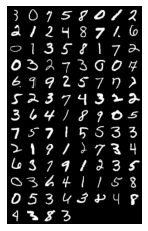

In [6]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片

reconsPath = './cgan_samples/real_images.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

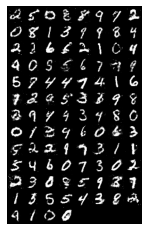

In [7]:
reconsPath = './cgan_samples/fake_images-100.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

(-0.5, 301.5, 301.5, -0.5)

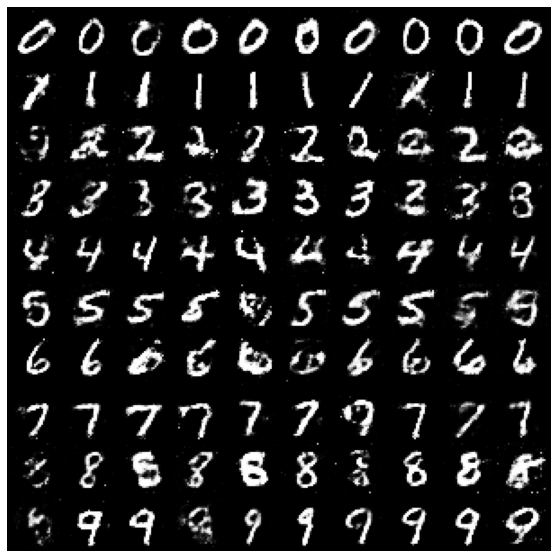

In [8]:
from torchvision.utils import make_grid
G.load_state_dict(torch.load('G.ckpt'))
z = torch.randn(100, 100).to(device)
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)

images = G(z, labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).detach().cpu().numpy(), cmap='binary')
ax.axis('off')

In [12]:
def generate_digit(generator, digit):
    z = torch.randn(1, 100).to(device)
    label = torch.LongTensor([digit]).to(device)
    img = generator(z, label).detach().cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

In [44]:
#for i in range (10):
generate_digit(G, 2)

In [ ]:
writer.add_scalars('scalars',{'g_loss':g_loss,'d_loss':d_loss},step)